<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Looking-for-signals-of-attention-(and-other-mental-states)-in-macaque-V2" data-toc-modified-id="Looking-for-signals-of-attention-(and-other-mental-states)-in-macaque-V2-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Looking for signals of attention (and other mental states) in macaque V2</a></span></li><li><span><a href="#Table-of-Contents" data-toc-modified-id="Table-of-Contents-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Table of Contents</a></span></li><li><span><a href="#1)-fit-model---autoencoder-+-GLM,-3-LVs" data-toc-modified-id="1)-fit-model---autoencoder-+-GLM,-3-LVs-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>1) fit model - autoencoder + GLM, 3 LVs</a></span></li><li><span><a href="#2)-analyze-latents" data-toc-modified-id="2)-analyze-latents-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>2) analyze latents</a></span></li><li><span><a href="#3)-look-at-cued-vs.-uncued-as-a-proxy-for-attention" data-toc-modified-id="3)-look-at-cued-vs.-uncued-as-a-proxy-for-attention-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>3) look at cued vs. uncued as a proxy for attention</a></span></li><li><span><a href="#4)-project-latents-onto-cued-vs.-uncued-vector" data-toc-modified-id="4)-project-latents-onto-cued-vs.-uncued-vector-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>4) project latents onto cued vs. uncued vector</a></span></li><li><span><a href="#5)-why-is-there-something-interesting-at-timestep-500?" data-toc-modified-id="5)-why-is-there-something-interesting-at-timestep-500?-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>5) why is there something interesting at timestep 500?</a></span><ul class="toc-item"><li><span><a href="#5a)-compare-the-different-trial-variables-with-the-latent-variables-to-find-relationships" data-toc-modified-id="5a)-compare-the-different-trial-variables-with-the-latent-variables-to-find-relationships-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>5a) compare the different trial variables with the latent variables to find relationships</a></span></li></ul></li><li><span><a href="#6)-retrain-models-with-different-#'s-of-latents" data-toc-modified-id="6)-retrain-models-with-different-#'s-of-latents-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>6) retrain models with different #'s of latents</a></span><ul class="toc-item"><li><span><a href="#7.-retrain-the-model-with-smoothed-inputs" data-toc-modified-id="7.-retrain-the-model-with-smoothed-inputs-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>7. retrain the model with smoothed inputs</a></span></li></ul></li></ul></div>

# Looking for signals of attention (and other mental states) in macaque V2

In [4]:
%matplotlib widget

import torch
import pickle
import model
import os.path
import numpy as np
from matplotlib.pyplot import *
from importlib import reload
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import utils
import lvutils as lv
import mattplotlib as m
import matth as math

def redo():
    reload(utils)
    reload(lv)
    reload(m)
    reload(math)

Invoking __init__.py for NDNT.utils


# Table of Contents
<ol>
<li><a href="#section1">fit model - autoencoder + GLM, 3 LVs</a></li>
<li><a href="#section2">analyze latents</a></li>
<li><a href="#section3">look at cued vs. uncued as a proxy for attention</a></li>
<li><a href="#section4">project latents onto cued vs. uncued vector</a></li>
<li><a href="#section5">why is there something interesting at trial 500</a></li>
<ol>
    <li><a href="#section5a">compare the different trial variables with the latent variables to find relationships</li>
    <li><a href="#section5b">play with UMAP to find interesting relationships</li>
</ol>
</a></li>
<li><a href="#section6">retrain the model with different #'s of latents</a></li>
<li><a href="#section7">retrain the model with smoothed inputs</a></li>
</ol>

In [5]:
# load the data
data = utils.load_data('ki_0126_V2_py.mat')

../../data/hn/ ki_0126_V2_py.mat
Loaded ki_0126_V2_py.mat
190541 frames, 26 units, 870 trials with 192 frames each


<a id='section1'></a>
# 1) fit model - autoencoder + GLM, 3 LVs

In [6]:
# only train if the model does not exist
if not os.path.isfile('model1.pickle'):
    # make the glm and train it
    # put the activation function at the end of this one since we are training it to produce the spikes
    pretrained_glm_layer = model.define_glm_layer(num_cells=data.NC, stim_dims=data.stim_dims, as_layer=False)
    pretrained_glm = model.NDN.NDN(layer_list = [pretrained_glm_layer], loss_type='poisson')
    model.fit_model(pretrained_glm, data)

    mean_lls_alone = []
    mean_lls_wglm = []

    num_latents = 3

    print('===== AUTOENCODER ALONE =====')
    lls_alone, latent_model = model.train_autoencoder(data, num_latents)
    # retrain if it started from a bad initialization
    while np.mean(lls_alone) < 0:
        print('LLs alone is BAD', str(np.mean(lls_alone)), 'RETRAINING')
        lls_alone, latent_model = model.train_autoencoder(data. num_latents)

    print('===== AUTOENCODER W/GLM =====')
    lls_wglm, pretrained_glm_plus_latent_model = model.train_autoencoder_and_glm(data, num_latents, pretrained_glm)
    # retrain if it started from a bad initialization
    while np.mean(lls_wglm) < 0 :
        print('LLs alone is BAD', str(np.mean(lls_wglm)), 'RETRAINING')
        lls_wglm, pretrained_glm_plus_latent_model = model.train_autoencoder_and_glm(data, num_latents, pretrained_glm)

    mean_lls_alone.append(np.mean(lls_alone))
    mean_lls_wglm.append(np.mean(lls_wglm))

    print('mean-adjusted LLs alone', np.mean(lls_alone))
    print('mean-adjusted LLs w/GLM', np.mean(lls_wglm))

In [7]:
# save out the model for later use
if not os.path.isfile('model1.pickle'):
    with open('model1.pickle', 'wb') as f:
        pickle.dump(pretrained_glm_plus_latent_model, f)

<a id='section2'></a>
# 2) analyze latents

In [8]:
# load the saved out latents
model = utils.load_model('model1.pickle')
R = utils.construct_R_matrix(data)
Z = utils.construct_Z_matrix(R, model, num_latents=3)
Z.shape # trials X time X latents

(870, 200, 3)

/tmp/ipykernel_28103/2967639006.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


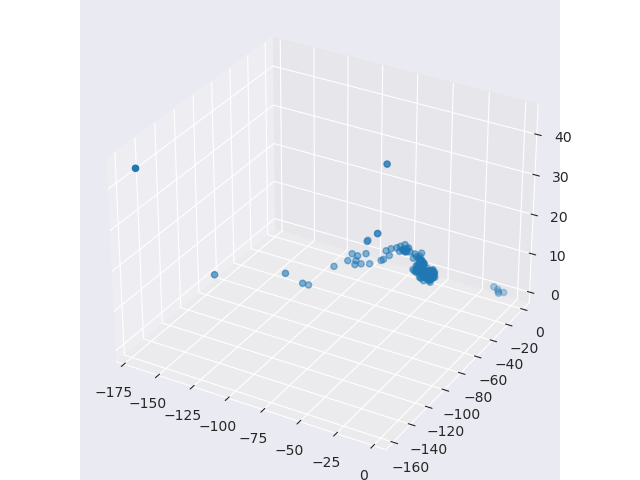

In [13]:
# plot the data averaged over time
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(np.mean(Z, axis=0).T[0],
           np.mean(Z, axis=0).T[1],
           np.mean(Z, axis=0).T[2])
plt.show()

/tmp/ipykernel_28103/2265042144.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


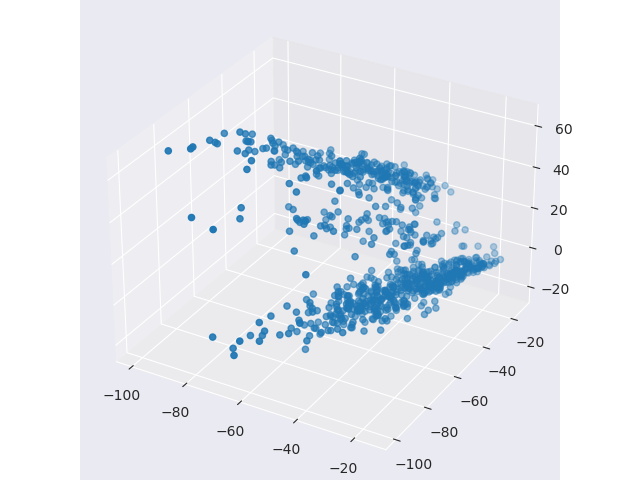

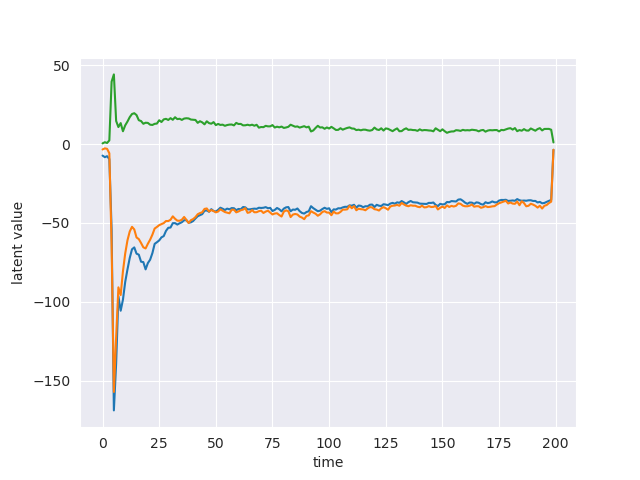

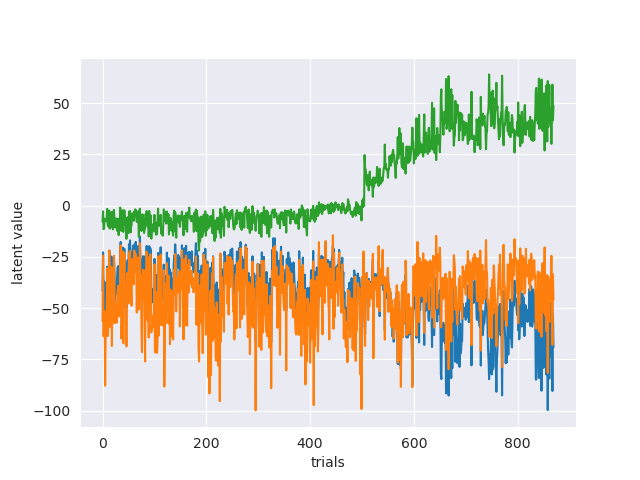

In [9]:
## 2a plot latents averaged over trials
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(np.mean(Z, axis=1).T[0],
           np.mean(Z, axis=1).T[1],
           np.mean(Z, axis=1).T[2])
plt.show()

## 2b plotted latents averaged over time
fig = plt.figure()
plt.plot(np.mean(Z, axis=0).T[0])
plt.plot(np.mean(Z, axis=0).T[1])
plt.plot(np.mean(Z, axis=0).T[2])
plt.xlabel("time")
plt.ylabel("latent value")
plt.show()

## 2c plotted latents averaged over trials
fig = plt.figure()
plt.plot(np.mean(Z, axis=1).T[0])
plt.plot(np.mean(Z, axis=1).T[1])
plt.plot(np.mean(Z, axis=1).T[2])
plt.xlabel("trials")
plt.ylabel("latent value")
plt.show()

<a id='section3'></a>
# 3) look at cued vs. uncued as a proxy for attention

In [10]:
## 3a find centroids of latents for cued and uncued trials
trcued = np.where(data.TRcued < 0)[0]
truncued = np.where(data.TRcued > 0)[0]
trcued_mean = np.mean(np.mean(Z[trcued], axis=1), axis=0)
truncued_mean = np.mean(np.mean(Z[truncued], axis=1), axis=0)

## 3b calculate vector between the centroids
centroid_vector = trcued_mean - truncued_mean
centroid_vector /= np.sqrt(centroid_vector @ centroid_vector.T)
centroid_vector = np.array([centroid_vector])
centroid_vector

array([[ 0.72960741,  0.68260177, -0.04156731]])

In [11]:
## 3c fit logistic regression model between cued and uncued
# separate cued-uncued points via logistic regression instead of centroids
from sklearn.linear_model import LogisticRegression

cued_trial_model = LogisticRegression(random_state=0).fit(np.mean(Z, axis=1), data.TRcued)

## 3d calculate hyperplane vector
hyperplane_vector = (cued_trial_model.coef_ / np.sqrt(cued_trial_model.coef_ @ cued_trial_model.coef_.T))
hyperplane_vector

array([[-0.80096257,  0.40420791, -0.44167288]])

<a id='section4'></a>
# 4) project latents onto cued vs. uncued vector

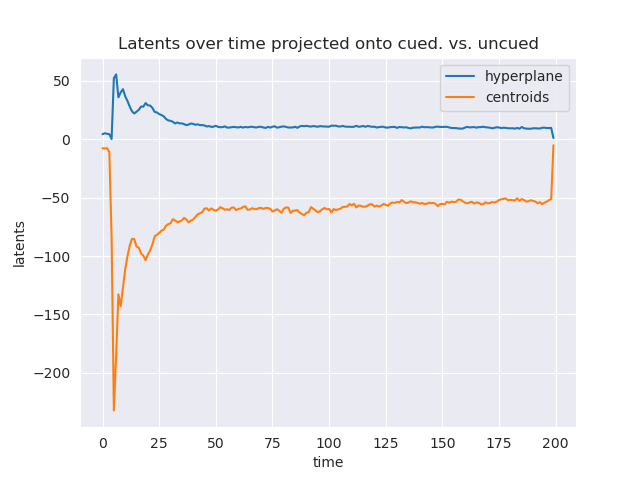

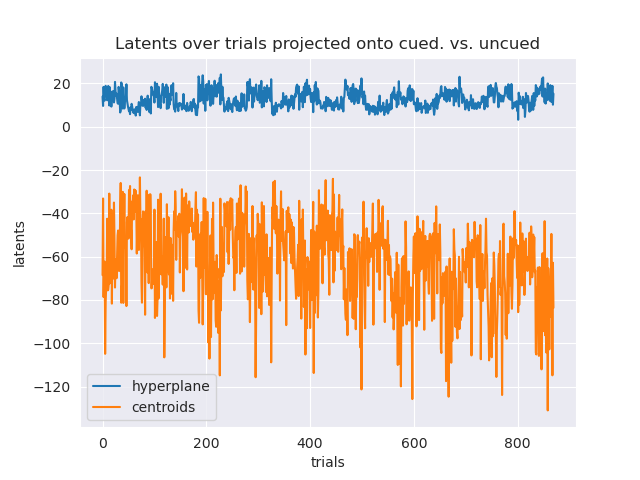

In [12]:
## 4a project the latents over time onto the cued vs. uncued vectors
fig = plt.figure()
plt.plot((hyperplane_vector @ np.mean(Z, axis=0).T).T, label="hyperplane")
plt.plot((centroid_vector @ np.mean(Z, axis=0).T).T, label="centroids")
plt.title("Latents over time projected onto cued. vs. uncued")
plt.xlabel("time")
plt.ylabel("latents")
plt.legend()
plt.show()

## 4b project the latents over trials onto the cued vs. uncued vectors
fig = plt.figure()
plt.plot((hyperplane_vector @ np.mean(Z, axis=1).T).T, label="hyperplane")
plt.plot((centroid_vector @ np.mean(Z, axis=1).T).T, label="centroids")
plt.title("Latents over trials projected onto cued. vs. uncued")
plt.xlabel("trials")
plt.ylabel("latents")
plt.legend()
plt.show()

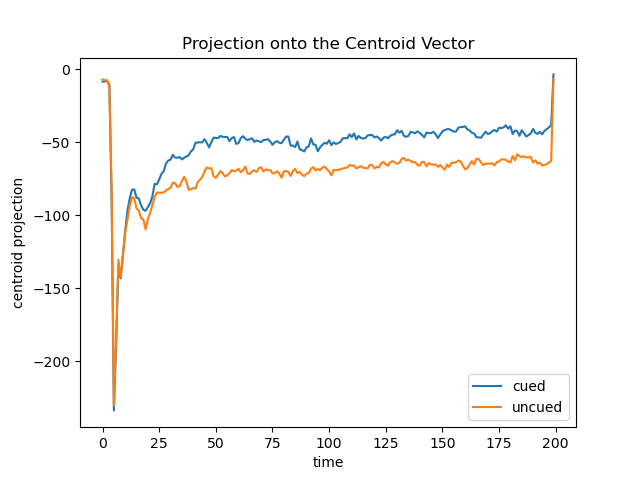

In [10]:
fig = plt.figure()
plt.plot((centroid_vector @ np.mean(Z[trcued], axis=0).T).T, label="cued")
plt.plot((centroid_vector @ np.mean(Z[truncued], axis=0).T).T, label="uncued")
plt.legend()
plt.xlabel("time")
plt.ylabel("centroid projection")
plt.title("Projection onto the Centroid Vector")
plt.show()

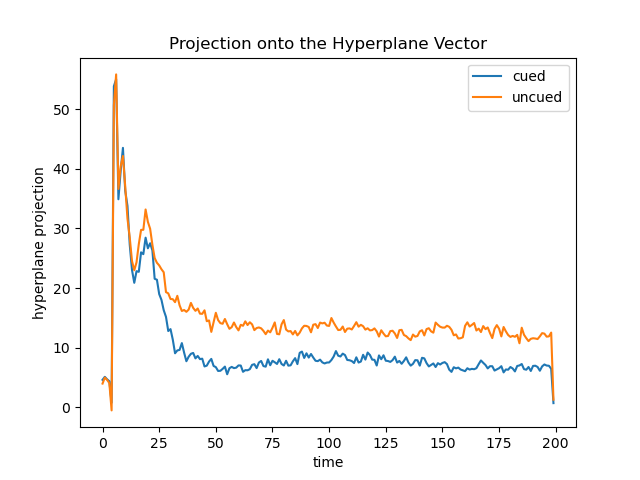

In [11]:
fig = plt.figure()
plt.plot((hyperplane_vector @ np.mean(Z[trcued], axis=0).T).T, label="cued")
plt.plot((hyperplane_vector @ np.mean(Z[truncued], axis=0).T).T, label="uncued")
plt.legend()
plt.xlabel("time")
plt.ylabel("hyperplane projection")
plt.title("Projection onto the Hyperplane Vector")
plt.show()

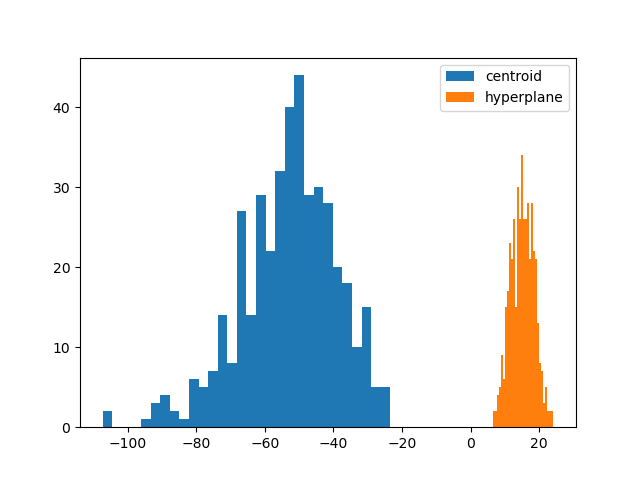

In [12]:
fig = plt.figure()
plt.hist((centroid_vector @ np.mean(Z[trcued], axis=1).T).T, bins=30, label="centroid")
plt.hist((hyperplane_vector @ np.mean(Z[truncued], axis=1).T).T, bins=30, label="hyperplane")
plt.legend()
plt.show()

<a id='section5'></a>
# 5) why is there something interesting at timestep 500?

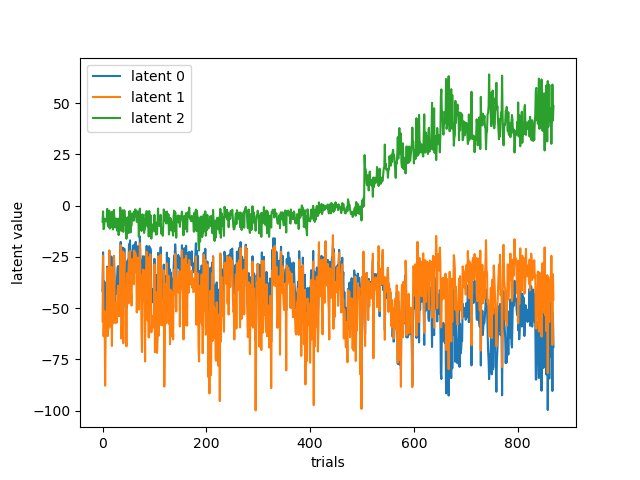

In [228]:
## 2c plotted latents averaged over trials
fig = plt.figure()
plt.plot(np.mean(Z, axis=1).T[0], label="latent 0")
plt.plot(np.mean(Z, axis=1).T[1], label="latent 1")
plt.plot(np.mean(Z, axis=1).T[2], label="latent 2")
plt.xlabel("trials")
plt.ylabel("latent value")
plt.legend()
plt.show()

<a id='section5b'></a>
## 5b) play with UMAP to find interesting relationships
<a href="http://localhost:4567/notebooks/lvs/umap.ipynb">[Notebook Link]</a>
<br />
<a href="https://github.com/NeuroTheoryUMD/mattjac/blob/main/lvs/umap.ipynb">[GitHub Link]</a>

<a id='section5b'></a>
## 5b) play with Spectral and HDBSCAN clustering to see if we can cluster the "arms" we see on the 3D plot
<a href="http://localhost:4567/notebooks/lvs/spectral.ipynb">[Notebook Link]</a>
<br />
<a href="https://github.com/NeuroTheoryUMD/mattjac/blob/main/lvs/spectral.ipynb">[GitHub Link]</a>

## 5c compare the HDBSCAN labeled clusters with the ones from UMAP -- it is confirmed, the UMAP labels perfectly match the "arms" in the 3D plot we saw above

In [31]:
hdbscan_labels = utils.depickle('arm_labels_hdbscan.pickle')
umap_labels = utils.depickle('arm_labels_umap.pickle')

In [32]:
np.unique(hdbscan_labels), np.unique(umap_labels)

(array([-1,  0,  1,  2]), array([0, 1, 2]))

/tmp/ipykernel_28103/1663296425.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


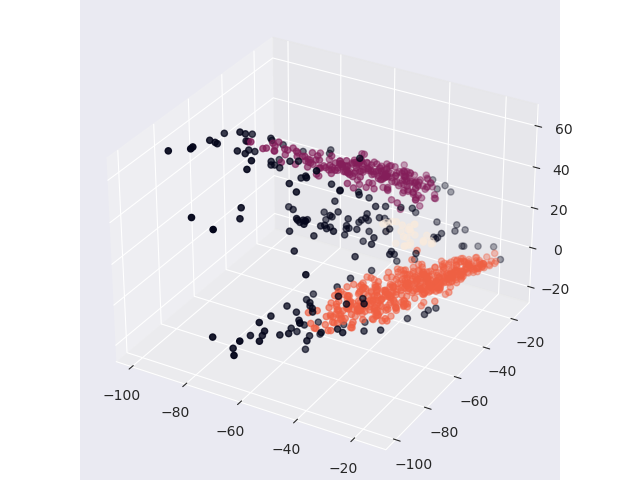

/tmp/ipykernel_28103/1663296425.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


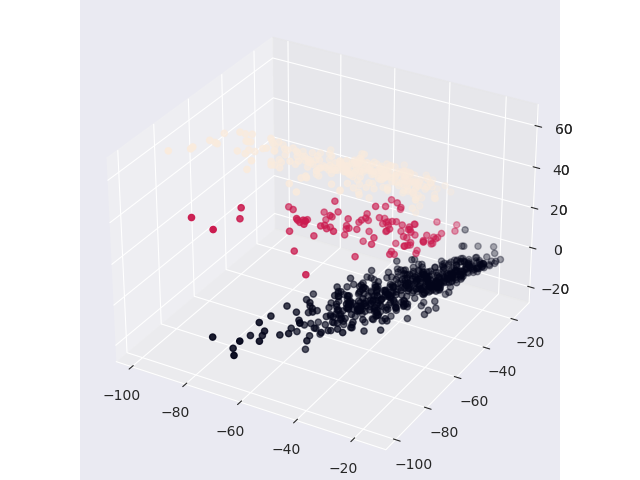

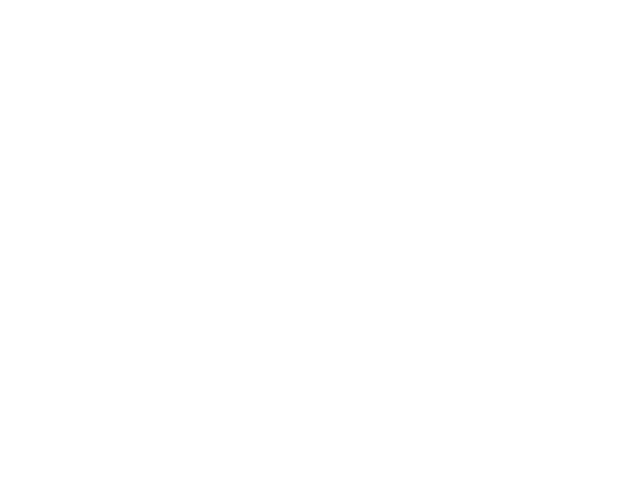

In [33]:
m.fig()
# plot the HDBSCAN calculated clusters
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(np.mean(Z, axis=1).T[0],
           np.mean(Z, axis=1).T[1],
           np.mean(Z, axis=1).T[2],
           c=hdbscan_labels)
plt.show()
ax = Axes3D(fig)
ax.scatter(np.mean(Z, axis=1).T[0],
           np.mean(Z, axis=1).T[1],
           np.mean(Z, axis=1).T[2],
           c=umap_labels)
plt.show()

## TODO: look at the smoothed firing rates over trials+time for each neuron. See if the firing rate for any neurons jump or change a bunch around trial 500 when it looks like the is a big change. Possibly due to drift.

## TODO: rerun the latent variable analyses and projections for only the timepoints before the big jump. See how that looks

It looks like the "arms" do, in fact represent, a big change in the neural firing after trial about 500.

<a id='section5a'></a>
## 5a) compare the different trial variables with the latent variables to find relationships
<a href="http://localhost:4567/notebooks/lvs/projections.ipynb">[Notebook Link]</a>
<br />
<a href="https://github.com/NeuroTheoryUMD/mattjac/blob/main/lvs/projections.ipynb">[GitHub Link]</a>

<a id='section6'></a>
# 6) retrain models with different #'s of latents

In [1]:
# 6a) determine D-prime between cued vs. uncued

test


<a id='section7'></a>
## 7. retrain the model with smoothed inputs